# Следење на контакти

Сега да се свртиме кон подетален преглед на начинот на ширење на епидемијата, а особено на прашањето кој кого инфицира. Работењето на оваа тематика е предмет на **следење на контакт (contact tracing)**, што е процес на утврдување на историјата на инфекцијата, додека болеста поминува низ популацијата. Во инфекција со SIR, ова се сведува на заклучок на моделот на заразени лица во текот на болеста.

Следењето на контакти се сведува на:

1. Давање податоци: колку луѓе биле заразени во популацијата? колку не биле заразени иако биле во контакт со заразено лице? и така натаму.

2. Овозможување третман на заразени лица, евентуално пред тие да бидат симптоматски.

3. Овозможување на распоредување на контрамерки за да се намали ширењето на болеста.

Во вистинска епидемија, аспектот за собирање податоци е од витално значење, бидејќи честопати сега ќе знаеме колку е нов болест е заразна. Аспектот на третман е исто така од витално значење за засегнатите лица, бидејќи раниот третман е често поефикасен. И за многу болести ќе има ефективни контрамерки како што е *карантин* што може да се наметне за да се намали ширењето на болеста уште повеќе. (Треба навистина да сметаме дека третманот е противмерка на ниво на популација, бидејќи лекуваните лица веројатно ќе ја шират болеста помалку од нелекуваните.)

Сепак, пронаоѓањето контакти во вистинска епидемија е макотрпен процес. Треба да ги идентификуваме заразените лица, или со нивно тестирање или со набудување на нивните симптоми, доколку тие се доволно различни за да се овозможи конечна идентификација. Потоа треба да ги идентификуваме сите со кои биле во контакт (нивната контактна мрежа) и да ги тестираме (или да ги набудуваме) за да утврдиме дали се заразени - а потоа да го повториме процесот со нивната контактна мрежа и така натаму.

За среќа, во симулирана епидемија, сите информации што ни се потребни се директно достапни. Ние ја знаеме мрежата за контакти **априори (apriori)** и можеме да ја инструментираме нашата симулација за да утврдиме начини на кои биле заразени поединци. Потоа можеме да го користиме овој инструментиран модел како основа за проучување на динамиката на болеста, стратегиите за третман и другите противмерки.


## Прогресија на епидемија

Повеќето заболувања кои се шират преку контакт споделуваат извонреден имот: ако имате болест, некој ви ја дал: точно една личност. Наспроти поимот во поранешните времиња дека сите болести резултираат од „лош воздух“, во многу случаи патогените микроорганизми поминуваат од една на друга личност со прилично директен контакт. Секој контакт нуди можност за инфекција од една на друга личност.

Ова е поедноставување, се разбира. Некои болести се пренесуваат преку воздухот или оставаат долготрајни траги на мебелот или предметите од кои може да се подигнат. Ако многу заразени луѓе се движат низ истиот простор, тие го зголемуваат „товарот“ на патогени во просторот и ја прават инфекцијата поверојатна - и исто така маскираат кој е тој што всушност го направил инфицирањето. Но, за сите видови на инфекции што ги разгледуваме во моментов, претпоставуваме дека тие пренесуваат од личност до личност.

Како изгледа, тогаш, ширењето на болеста низ популацијата?

Ајде да поедноставиме малку повеќе и да претпоставиме дека имаме единствено заразено лице во целосно подложна популација. Како се шири инфекцијата? Ајде да ја пронајдеме инфекцијата како што напредува. За да го прикажеме ова малку ќе треба да го малку "hardcodе"-ираме за да го направиме механизмот поексплицитен.

Ова може да го споредме со описот на SIR од претходните примери.

Прво создаваме мала мрежа за ER и ја „засадуваме“ со единствено заразено лице, кое го чуваме во самата мрежа како атрибут. Потоа чекориме низ времето и на секој чекор ги разгледуваме соседите на секој заразен јазол. Ако се подложни, ги заразуваме со одредена веројатност и - доколку се заразат - ја запишуваме нивната инфекција за следниот временски запис. Ние исто така го обележуваме работ што го мина инфекцијата.

In [3]:
import numpy
import networkx
import epyc
import epydemic
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import seaborn

matplotlib.rcParams['figure.dpi'] = 90
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1)

In [4]:
def stepEpidemic(g):
    # Следење на прогресот преку време 
    inf = []

    # Екстракција на сите инфицирани јазли 
    infecteds = [n for n in g.nodes
                 if 'infected' in g.nodes[n].keys()]

    # Прогресија на епидемијата
    for n in infecteds:
        infs = []
        if 'infected' in g.nodes[n].keys():
            # зарази го секој поддлежен јазол
            # со веројатност pInfect (beta)
            for m in g.neighbors(n):
                # игнорирај ги сите веќе инфрицирани соседи 
                if 'infected' not in g.nodes[m].keys():
                    # одлучи дали ќе заразиш или не
                    if numpy.random.random() < pInfect:
                        # заразуваме, запиши го ова и врската
                        g.nodes[m]['infected'] = True
                        infs.append(m)
                        g.edges[n, m]['occupied'] = True

        # мапирај ја инфекцијата 
        if len(infs) > 0:
            inf.append((n, infs))

    # врати мапа од кој кого заразил
    return inf

Потоа можеме да го исцртуваме напредокот на инфекцијата преку мрежата како што одминува времето.

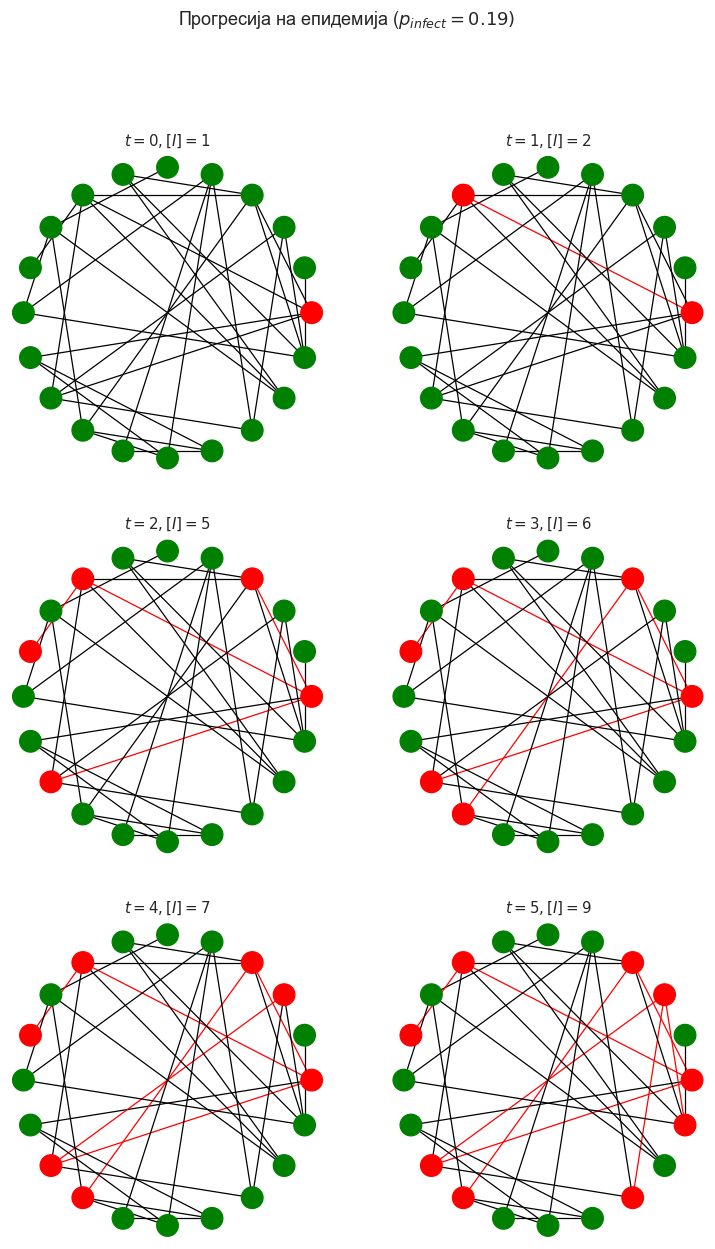

In [8]:
def drawEpidemic(g, ax, t):
    # бои на јазли (зелени - поддлежни, црвени - заразени)
    inf = 0
    nodes = list(g.nodes)
    ncs = ['green'] * len(nodes)
    for i in range(len(nodes)):
        n = nodes[i]
        if 'infected' in g.nodes[n].keys():
            ncs[i] = 'red'
            inf += 1

    # бои на врски (црни - незаразени, црвени - заразени)
    edges = list(g.edges)
    ecs = ['black'] * len(edges)
    for i in range(len(edges)):
        (n, m) = edges[i]
        if 'occupied' in g.edges[n, m].keys():
            ecs[i] = 'red'

    # цртај дрво на контакти
    networkx.draw_circular(g, ax=ax,
                           node_color=ncs, edge_color=ecs)
    ax.set_title('$t = {t}, [I] = {i}$'.format(t=t, i=inf))


(fig, axs) = plt.subplots(3, 2, figsize=(10, 16))

# Направи мала ЕР мрежа од 20 јазли
N = 20
pEdge = 0.2
g = networkx.gnp_random_graph(N, pEdge)

# Зарази го ПРВИОТ човек
g.nodes[0]['infected'] = True
infs = [[(None, [0])]]

pInfect = 0.19

t = 0
for x in range(3):
    for y in range(2):
        # цртај ги заразените јазли и врските каде настанале
        ax = axs[x][y]
        drawEpidemic(g, ax, t)

        # шифтај за временски интервал
        infs.append(stepEpidemic(g))
        t += 1

# Исцртај и зачувај график
plt.suptitle('Прогресија на епидемија ($p_{\\mathit{infect}} = ' + '{i})$'.format(i=pInfect))
plt.savefig('images/3_1_Epidemic-progress.png')
plt.show()

Постојат неколку работи што треба да се забележат овде. Прво, воочуваме колку брзо се зголемува бројот на заразени (означени $[I]$ на бројките) луѓе! Болеста брзо преминува од некаде до секаде, и само експлодира како што расте: стапката со која се шири се зголемува со зголемувањето на процентот на заразени луѓе, што е основната карактеристика на експоненцијалниот раст.

Второ, забележете колку неколку рабови беа пресечени. Ова има смисла, бидејќи може да има само еден раб на „пренос“ за секој јазол, што ќе биде само мал дел од вкупните јазли.

## Дрва на контакти

Ова можеме да го направиме појасно со цртање на процесот малку поинаку - слично како дрва на одлука. (инспирација од [статијата](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5607590/). Наместо да ја цртаме мрежата како целина и да го покажеме начинот на ширење на инфекцијата, ние ќе се фокусираме само на заразените јазли и ќе покажеме како тие се однесуваат - со други зборови, кој на кого пренесува болест.

Започнуваме од $t = 0$ со еден заразен јазол. Во следниот временски чекор ќе нацртаме втора линија на јазли што биле заразени од овој јазол, поврзани со него со рабови. Во следниот временски чекор ќе нацртаме трета линија на оние кои биле заразени од тие јазли и така натаму како што одминува времето. 

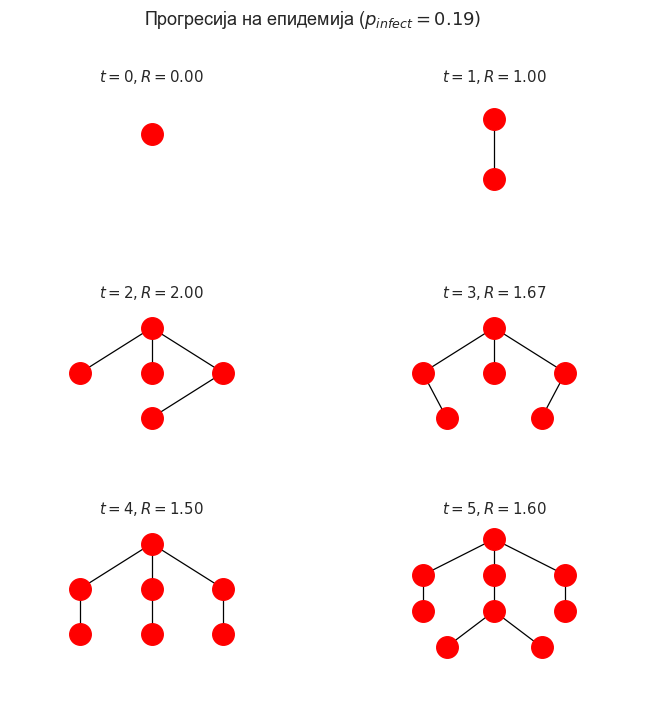

In [9]:
def drawContactTree(ax, t, ct):
    # направи ја листата на зарази во мрежа
    g = networkx.Graph()
    for infs in ct:
        for (n, ms) in infs:
            for m in ms:
                g.add_node(m)
                if n is not None:
                    g.add_edge(n, m)

    # пресметај ги сите слоеви во дрвото и бројот на 
    # зарази за секоја индивидуа
    secondaries = dict()
    ns = [0]
    layers = [ns]
    while len(ns) > 0:
        layer = []
        for n in ns:
            gs = set(g.neighbors(n))
            if len(layers) > 1:
                gs -= set(layers[-2])
            layer.append(list(gs))
            if len(gs) > 0:
                secondaries[n] = len(gs)
        ns = [n for cs in layer for n in cs]
        if len(ns) > 0:
            layers.append(ns)

    # пресметај локации
    pos = dict()
    dy = 1.0 / (len(layers) + 1)
    y = 1.0 - dy / 2
    for layer in layers:
        dx = 1.0 / (len(layer) + 1)
        x = dx
        for n in layer:
            pos[n] = (x, y)
            x += dx
        y -= dy

    # пресметај го R во дадено време t
    if len(secondaries.keys()) > 0:
        Rt = sum(secondaries.values()) / len(secondaries.keys())
    else:
        Rt = 0

    # исцртај го дрвото
    networkx.draw_networkx(g, pos, ax=ax,
                           node_color='red', with_labels=False)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.axis('off')
    ax.set_title('$t = {t}, R = {rt:.2f}$'.format(t=t, rt=Rt))


(fig, axs) = plt.subplots(3, 2, figsize=(9, 9))

t = 0
for x in range(3):
    for y in range(2):
        ax = axs[x][y]
        layers = infs[:(t + 1)]
        drawContactTree(ax, t, layers)
        t += 1

# прикажи и зачувај фигура
plt.suptitle('Прогресија на епидемија ($p_{\\mathit{infect}} = ' + '{i})$'.format(i=pInfect))
plt.savefig('images/3_2_Contact-tree.png')
plt.show()

Оваа слоевита структура е **контактно дрво (contact tree)**. Највисок јазол е **нулти пациент (patient zero)**, првото лице заразено во епидемијата. Оние што се наоѓаат во следниот слој надолу се првиот пакет секундарни случаи, лицата заразени од нулиот пациент. И така натаму. Забележете дека бидејќи еден јазол останува заразен (во овој многу едноставен модел) тој може да продолжи да ги инфицира јазлите, така што слоевите може да растат со текот на времето, бидејќи се појавуваат секундарни случаи од секој заразен.

Компјутерските научници го нарекуваат горниот јазол на дрвото како **корен (root)** и секогаш го цртаат коренот на врвот на дијаграмот на дрвото.

Исто интересно е што забележав е дека на горниот дијаграм $R$ (spreading factor) се намалува со текот на времето. 

Зошто е тоа така? 

Тоа е затоа што секоја индивидуа може да се зарази само еднаш и, откако ќе се зарази, не може да се зарази повторно. Подоцна заразените лица имаат поголема веројатност да имаат соседи кои се веќе заразени, и затоа имаат помалку можност да ја пренесат болеста на нови луѓе. Овој феномен на „полнење“ на мрежата со заразени лица - а подоцна и во SIR, со оние што биле отстранети - е причината зошто епидемиите природно изумираат без нужно да ја инфицираат целата популација. Тоа е исто така основа за вакцинација, што е тема на која планирам да дадам примери. 